In [4]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from Data import Data
from Unet import Unet

In [5]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def dice_sim(pred, truth):
    epsilon = 1e-8
    num_batches = pred.size(0)
    m1 = pred.view(num_batches, -1).bool()
    m2 = truth.view(num_batches, -1).bool()

    intersection = torch.logical_and(m1, m2).sum(dim=1)
    return (((2. * intersection + epsilon) / (m1.sum(dim=1) + m2.sum(dim=1) + epsilon)).sum(dim=0))/2

train = Data('train', None)
val = Data('validate', None)
test = Data('test', None)

batch_size = 2

train_generator = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True, num_workers=0)
val_generator = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True, num_workers=0)
test_generator = torch.utils.data.DataLoader(test, batch_size=2, shuffle=True, num_workers=0)


In [6]:

model = Unet().to(device)
#model = torch.load(dir+"model", map_location=torch.device("cpu")) To load pretrained model

loss_fn = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-9)
train_size = len(train)
val_size = len(val)


In [18]:
num_epochs = 2


In [19]:
df = pd.DataFrame([],
                  columns=['Epoch','TrainLoss', 'TrainAcc', 'ValLoss', 'ValAcc'])

In [20]:
df

,Epoch,TrainLoss,TrainAcc,ValLoss,ValAcc


In [21]:
from datetime import datetime
print(datetime.now(tz=None))


2021-11-28 22:34:21.620667


In [30]:
for epoch in range(9,30):
    print(datetime.now(tz=None))
    print(df.tail)

    running_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    train_acc = 0.0

    # Training
    for i, data in enumerate(train_generator):
        image, truth = data
        truth = truth/255
        predictions = model(image)
        loss = loss_fn(predictions, truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_acc += dice_sim(predictions, truth)*100
        #print("Running iteration i=", i, " running loss=", running_loss)
        
    # Validation
    with torch.no_grad():
        for i, data in enumerate(val_generator):
            image, truth = data
            truth = truth/255
            predictions = model(image)
            predictions = torch.round(predictions) # Rounding the predictions for classification
            loss = loss_fn(predictions, truth)
            val_loss += loss.item()
            val_acc += dice_sim(predictions, truth)*100

    epoch_train_loss = running_loss / (train_size//batch_size+1)
    epoch_val_loss = val_loss / (val_size//batch_size+1)
    epoch_val_acc = val_acc / (val_size//batch_size+1)
    epoch_train_acc = train_acc / (train_size//batch_size+1)
    scheduler.step(epoch_val_loss) # LR Scheduler
    
    torch.save(model.state_dict(), f"/home/ubuntu/aae/models/aae-ep-{epoch}")
    df.loc[epoch] = [epoch, epoch_train_loss, epoch_train_acc.item(), epoch_val_loss, epoch_val_acc.item()]
    print(df.tail)


2021-11-28 23:27:14.979762
<bound method NDFrame.tail of    Epoch  TrainLoss   TrainAcc   ValLoss     ValAcc
0    0.0   0.139771  45.618732  5.711706  68.822235
1    1.0   0.114984  45.618744  2.718837  74.948235
2    2.0   0.102017  45.618759  2.721866  75.372414
3    3.0   0.093084  45.618740  3.526864  73.650551
4    4.0   0.085401  45.618759  2.122324  76.152641
5    5.0   0.079649  45.618767  2.637085  75.088326
6    6.0   0.074722  45.618748  1.645459  77.025414
7    7.0   0.073287  45.618759  2.389257  75.849205
8    8.0   0.067408  45.618732  2.703285  75.049606>
<bound method NDFrame.tail of    Epoch  TrainLoss   TrainAcc   ValLoss     ValAcc
0    0.0   0.139771  45.618732  5.711706  68.822235
1    1.0   0.114984  45.618744  2.718837  74.948235
2    2.0   0.102017  45.618759  2.721866  75.372414
3    3.0   0.093084  45.618740  3.526864  73.650551
4    4.0   0.085401  45.618759  2.122324  76.152641
5    5.0   0.079649  45.618767  2.637085  75.088326
6    6.0   0.074722  45.6187

<bound method NDFrame.tail of     Epoch  TrainLoss   TrainAcc   ValLoss     ValAcc
0     0.0   0.139771  45.618732  5.711706  68.822235
1     1.0   0.114984  45.618744  2.718837  74.948235
2     2.0   0.102017  45.618759  2.721866  75.372414
3     3.0   0.093084  45.618740  3.526864  73.650551
4     4.0   0.085401  45.618759  2.122324  76.152641
5     5.0   0.079649  45.618767  2.637085  75.088326
6     6.0   0.074722  45.618748  1.645459  77.025414
7     7.0   0.073287  45.618759  2.389257  75.849205
8     8.0   0.067408  45.618732  2.703285  75.049606
9     9.0   0.063796  45.618748  1.906816  76.616547
10   10.0   0.062898  45.618752  1.860786  76.718987
11   11.0   0.061340  45.618767  2.570717  74.505493
12   12.0   0.049998  45.618740  1.980824  76.287514
13   13.0   0.046820  45.618740  1.679857  77.073074
14   14.0   0.045548  45.618732  1.624820  77.110229
15   15.0   0.044546  45.618736  1.725007  76.973289>
2021-11-29 00:03:23.825550
<bound method NDFrame.tail of     Epoch  

<bound method NDFrame.tail of     Epoch  TrainLoss   TrainAcc   ValLoss     ValAcc
0     0.0   0.139771  45.618732  5.711706  68.822235
1     1.0   0.114984  45.618744  2.718837  74.948235
2     2.0   0.102017  45.618759  2.721866  75.372414
3     3.0   0.093084  45.618740  3.526864  73.650551
4     4.0   0.085401  45.618759  2.122324  76.152641
5     5.0   0.079649  45.618767  2.637085  75.088326
6     6.0   0.074722  45.618748  1.645459  77.025414
7     7.0   0.073287  45.618759  2.389257  75.849205
8     8.0   0.067408  45.618732  2.703285  75.049606
9     9.0   0.063796  45.618748  1.906816  76.616547
10   10.0   0.062898  45.618752  1.860786  76.718987
11   11.0   0.061340  45.618767  2.570717  74.505493
12   12.0   0.049998  45.618740  1.980824  76.287514
13   13.0   0.046820  45.618740  1.679857  77.073074
14   14.0   0.045548  45.618732  1.624820  77.110229
15   15.0   0.044546  45.618736  1.725007  76.973289
16   16.0   0.044581  45.618748  1.617805  77.208679
17   17.0   0.04

<bound method NDFrame.tail of     Epoch  TrainLoss   TrainAcc   ValLoss     ValAcc
0     0.0   0.139771  45.618732  5.711706  68.822235
1     1.0   0.114984  45.618744  2.718837  74.948235
2     2.0   0.102017  45.618759  2.721866  75.372414
3     3.0   0.093084  45.618740  3.526864  73.650551
4     4.0   0.085401  45.618759  2.122324  76.152641
5     5.0   0.079649  45.618767  2.637085  75.088326
6     6.0   0.074722  45.618748  1.645459  77.025414
7     7.0   0.073287  45.618759  2.389257  75.849205
8     8.0   0.067408  45.618732  2.703285  75.049606
9     9.0   0.063796  45.618748  1.906816  76.616547
10   10.0   0.062898  45.618752  1.860786  76.718987
11   11.0   0.061340  45.618767  2.570717  74.505493
12   12.0   0.049998  45.618740  1.980824  76.287514
13   13.0   0.046820  45.618740  1.679857  77.073074
14   14.0   0.045548  45.618732  1.624820  77.110229
15   15.0   0.044546  45.618736  1.725007  76.973289
16   16.0   0.044581  45.618748  1.617805  77.208679
17   17.0   0.04

<bound method NDFrame.tail of     Epoch  TrainLoss   TrainAcc   ValLoss     ValAcc
0     0.0   0.139771  45.618732  5.711706  68.822235
1     1.0   0.114984  45.618744  2.718837  74.948235
2     2.0   0.102017  45.618759  2.721866  75.372414
3     3.0   0.093084  45.618740  3.526864  73.650551
4     4.0   0.085401  45.618759  2.122324  76.152641
5     5.0   0.079649  45.618767  2.637085  75.088326
6     6.0   0.074722  45.618748  1.645459  77.025414
7     7.0   0.073287  45.618759  2.389257  75.849205
8     8.0   0.067408  45.618732  2.703285  75.049606
9     9.0   0.063796  45.618748  1.906816  76.616547
10   10.0   0.062898  45.618752  1.860786  76.718987
11   11.0   0.061340  45.618767  2.570717  74.505493
12   12.0   0.049998  45.618740  1.980824  76.287514
13   13.0   0.046820  45.618740  1.679857  77.073074
14   14.0   0.045548  45.618732  1.624820  77.110229
15   15.0   0.044546  45.618736  1.725007  76.973289
16   16.0   0.044581  45.618748  1.617805  77.208679
17   17.0   0.04

<bound method NDFrame.tail of     Epoch  TrainLoss   TrainAcc   ValLoss     ValAcc
0     0.0   0.139771  45.618732  5.711706  68.822235
1     1.0   0.114984  45.618744  2.718837  74.948235
2     2.0   0.102017  45.618759  2.721866  75.372414
3     3.0   0.093084  45.618740  3.526864  73.650551
4     4.0   0.085401  45.618759  2.122324  76.152641
5     5.0   0.079649  45.618767  2.637085  75.088326
6     6.0   0.074722  45.618748  1.645459  77.025414
7     7.0   0.073287  45.618759  2.389257  75.849205
8     8.0   0.067408  45.618732  2.703285  75.049606
9     9.0   0.063796  45.618748  1.906816  76.616547
10   10.0   0.062898  45.618752  1.860786  76.718987
11   11.0   0.061340  45.618767  2.570717  74.505493
12   12.0   0.049998  45.618740  1.980824  76.287514
13   13.0   0.046820  45.618740  1.679857  77.073074
14   14.0   0.045548  45.618732  1.624820  77.110229
15   15.0   0.044546  45.618736  1.725007  76.973289
16   16.0   0.044581  45.618748  1.617805  77.208679
17   17.0   0.04

In [27]:
model.load_state_dict(torch.load("/home/ubuntu/aae/models/aae-ep-8", map_location="cuda:0"))  
model.to(device)

Unet(
  (inc): start_conv(
    (conv): res_conv(
      (conv1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (down1): down_conv(
    (conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): res_conv(
        (conv1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReL

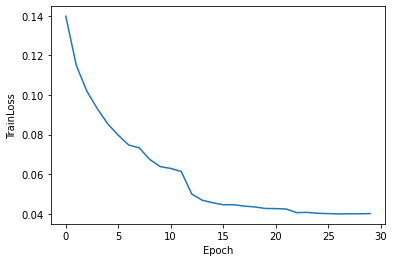

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.lineplot(x = "Epoch", y = "TrainLoss", err_style='bars', data = df)
plt.show()

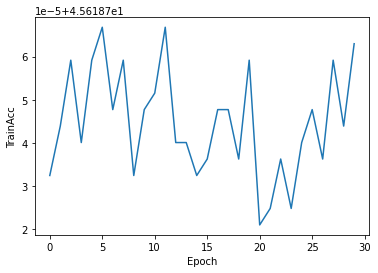

In [32]:
sns.lineplot(x = "Epoch", y = "TrainAcc", err_style='bars', data = df)
plt.show()

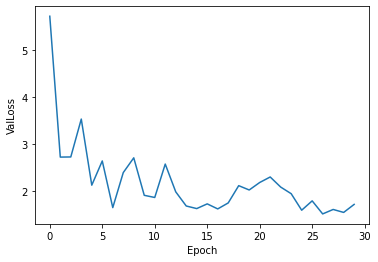

In [33]:
sns.lineplot(x = "Epoch", y = "ValLoss", err_style='bars', data = df)
plt.show()

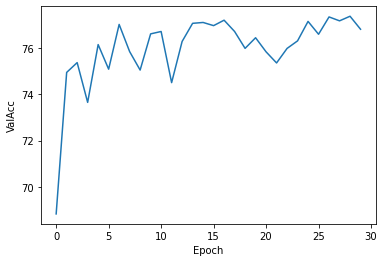

In [34]:
sns.lineplot(x = "Epoch", y = "ValAcc", err_style='bars', data = df)
plt.show()

In [35]:
df.to_csv('/home/ubuntu/aae/models/output-1-30.csv')